In [23]:
metadata = {
    'Author      ': 'Jay Annadurai',
    'Date        ': '22 Feb 2024',
    'Project     ': 'A2-HalfLives',
    'Version     ': 1.0,
    'Description ': 'Reads Data from a Set of 3 Timecourse Experiments for YORF Products, Calculates Half-Lives, and Selects 10% Extremes for Functional Analysis'
}

In [24]:
# Input Matrix Files
matrix = "DecayTimecourse"
input_folder = "data/"
output_folder = "output/"

In [25]:
# Import Libraries
import pandas as pd  # Data Reading
import seaborn as sb  # Advanced Data Visualization
import matplotlib.pyplot as plt  # Data Visualization
import numpy as np  # Computation
import scipy as sp # Statistical Methods

In [26]:
###############
# Import Data #
###############

def read_matrix_to_df(folder: str, file_name: str, extension: str):
    # Function Reads the Matrix and Returns it as a Pandas DF

    # Read the TSV
    extension = "." + extension.lower()
    file_path = folder + file_name + extension
    matrix_df = pd.read_csv(file_path, sep='\t', header=0)

    # Excluding the non-numeric column (assuming it's the first column)
    numeric_df = matrix_df.select_dtypes(include=[float, int])

    # Generate the 1D Vector of Values
    matrix_vector = numeric_df.values.flatten()

    # Return a Dict with the File Name, the Original DF, the Numeric DF, and the Flattened Vector
    return {"name": file_name, "df": matrix_df, "numeric_df": numeric_df, "vector": matrix_vector}

In [27]:
# Import the Dataframe
decay_df_dict = read_matrix_to_df(input_folder, matrix,"txt")
decay_df = decay_df_dict["df"]

In [28]:
# View the DF
decay_df

,Time course #,timecourse1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 18,timecourse3,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,YORF,0.0,5.000000,10.000000,15.000000,20.000000,30.000000,40.000000,50.000000,60.000000,...,60.000000,0.0,5.000000,10.000000,15.000000,20.000000,30.000000,40.000000,50.000000,60.000000
1,YAL026C,1.0,0.703032,NaN,NaN,NaN,0.713088,0.332218,0.215325,0.226495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YDR148C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.374799,1.0,0.968435,NaN,0.551961,0.430054,0.483829,0.398754,0.223900,0.246680
3,YIL125W,1.0,1.176639,0.823170,0.556528,NaN,0.712678,0.427962,0.320204,0.276578,...,NaN,1.0,0.830889,0.577928,0.812495,0.591393,0.564740,0.450448,0.494973,0.374799
4,YLR240W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,0.930606,NaN,0.637943,NaN,0.610046,0.340338,0.260625,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6180,YHR217C,1.0,NaN,NaN,NaN,NaN,1.086471,-0.683673,0.853815,0.131799,...,0.621047,1.0,0.720896,0.217361,0.372403,-0.245485,-1.210194,0.255268,-1.275420,NaN
6181,YPR202W,1.0,-1.614135,-1.987968,-1.572060,-2.140755,NaN,-2.624831,NaN,-2.929300,...,-2.435356,1.0,-1.062584,-1.766918,-1.066211,-1.900540,-1.659776,-2.599347,-3.163888,-2.765729
6182,YFL063W,1.0,0.709353,NaN,NaN,0.384163,-0.003912,-1.611686,NaN,-1.417343,...,NaN,1.0,NaN,-1.107214,-0.985987,-1.409186,-1.515253,-2.073723,-2.828369,NaN
6183,YDR543C,1.0,0.384179,-11.808840,-12.892562,NaN,-88.868870,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
###################################################
# Split the Dataframes per Time Course Experiment #
###################################################

# Initialize a list to keep track of the start indices of each 'timecourse' set
timecourse_start_indices = []

# Identify columns that start with 'timecourse'
# Generate the index intervals for each timecourse dataset
for col_index, col in enumerate(decay_df.columns):
    if col.startswith('timecourse'):
        timecourse_start_indices.append(col_index)

# Add the last column index to cover the range for the last segment
timecourse_start_indices.append(len(decay_df.columns))

# Generate the actual intervals as ranges
timecourse_interval_ranges = []
for i,start_index in enumerate(timecourse_start_indices):
    # Skip the first element
    if i == 0: continue
    
    # The interval from the previous index to the current index are the interval endpoints for each time course set
    interval_range = range(timecourse_start_indices[i-1],timecourse_start_indices[i])
    
    # Append the Interval Range into the List
    timecourse_interval_ranges.append(interval_range)

In [30]:
# Initialize the List to store the individual Time Course DFs
decay_timecourse_dfs = []

# Iterate through the Ranges corresponding to the Endpoints of each Time Course
for i,timecourse_interval_range in enumerate(timecourse_interval_ranges):
    # Time Course Set is the index + 1
    timecourse_set = i + 1
    
    # Select the Range of each Time Course 
    # Note iloc is the subset of the dataframe
    # iloc uses indices verus loc which uses column and row labels
    decay_timecourse_df = decay_df.iloc[:,timecourse_interval_range]
    
    # Add the first column which is the label for each row
    # The first column was lost when the df was split and must be fused
    # Fusion is performed via Pandas' df concat along the 
    decay_df_row_labels = decay_df.iloc[:, 0]
    decay_timecourse_df = pd.concat([decay_df_row_labels, decay_timecourse_df], axis="columns")
    
    # Set the Column Labels, i.e. the Headers, to the Row of Index = 0
    decay_timecourse_df.columns = decay_timecourse_df.iloc[0,:]

    # Drop the First Row which is the Header but Keep All the Columns
    decay_timecourse_df = decay_timecourse_df.iloc[1:,:]
    
    # Reset the Index In-Place
    # decay_timecourse_df.reset_index(drop=True, inplace=True)

    # Attach the Individual DF to the List of DFs
    decay_timecourse_dfs.append(decay_timecourse_df)

    # Debug to Validate the DF, display the Header
    print(f"Decay Timecourse {timecourse_set} Dataframe from {str(timecourse_interval_range)} \n\n", decay_timecourse_df.head(3), "\n")
    
# decay_timecourse_dfs now contains individual dfs for each time course

Decay Timecourse 1 Dataframe from range(1, 10) 

 0     YORF  0.0       5.0     10.0      15.0  20.0      30.0      40.0  \
1  YAL026C  1.0  0.703032      NaN       NaN   NaN  0.713088  0.332218   
2  YDR148C  NaN       NaN      NaN       NaN   NaN       NaN       NaN   
3  YIL125W  1.0  1.176639  0.82317  0.556528   NaN  0.712678  0.427962   

0      50.0      60.0  
1  0.215325  0.226495  
2       NaN       NaN  
3  0.320204  0.276578   

Decay Timecourse 2 Dataframe from range(10, 19) 

 0     YORF  0.0       5.0      10.0      15.0      20.0      30.0      40.0  \
1  YAL026C  1.0  1.160240       NaN  0.800430  1.129715  0.645523  0.344193   
2  YDR148C  1.0  0.830889  0.577928  0.812495  0.591393  0.564740  0.450448   
3  YIL125W  1.0  0.978603  0.574234  0.655818  0.685354  0.705738  0.403536   

0      50.0      60.0  
1  0.635076       NaN  
2  0.494973  0.374799  
3  0.480144       NaN   

Decay Timecourse 3 Dataframe from range(19, 28) 

 0     YORF  0.0       5.0      10.0   

In [31]:
###################################################
# Restructure DFs into Optimal Form for Analytics #
###################################################

# Initialize an array to store the long dataframes
decay_timecourse_long_dfs = []

for i,decay_timecourse_df in enumerate(decay_timecourse_dfs):
    # Iterate through the DFs and Convert it into the Long Form
    
    # Time Course Set is the index + 1
    timecourse_set = i + 1
    
    # Use Pandas Melt
    decay_timecourse_long_df = pd.melt(
        decay_timecourse_df,
        # The Identifier Column
        id_vars=["YORF"],
        # The Columns to Melt into a Single Column
        # In this case, we're ignoring the 'YORF' column and melting the rest
        value_vars=decay_timecourse_df.iloc[:,1:],
        # Name of the Melted Columns
        var_name="Time",
        # Name of the Values of the Melted Columns
        value_name="PopulationFraction"
    )
    
    # Drop any NaN Values
    decay_timecourse_long_df.dropna(subset=["PopulationFraction"],inplace=True)
    
    # Set any 0 Values to 0.0001 for the sake of including the value
    
    
    # Sort by the Yeast Open Reading Frame (YORF)
    decay_timecourse_long_df.sort_values(by=["YORF","Time"],inplace=True)
    
    # Check the Data types of the Columns
    # print(decay_timecourse_long_df.dtypes)
    # Time was actually an 'object', must be converted to integer
    decay_timecourse_long_df['Time'] = decay_timecourse_long_df['Time'].astype(int)
    
    # Reset the Index
    decay_timecourse_long_df.reset_index(drop=True,inplace=True)
    
    # Insert the Long DF into the Array
    decay_timecourse_long_dfs.append(decay_timecourse_long_df)

    # Debug to Validate the DF, display the Header
    print(f"Decay Timecourse {str(timecourse_set)} \n\n", decay_timecourse_long_df.head(10), "\n")
    

Decay Timecourse 1 

     YORF  Time  PopulationFraction
0  Q0010     0            1.000000
1  Q0010     5            0.752075
2  Q0010    10            0.950428
3  Q0010    20            0.780242
4  Q0010    30            0.929908
5  Q0010    40            0.491377
6  Q0010    50            0.675198
7  Q0010    60            0.746557
8  Q0050     0            1.000000
9  Q0050     5            0.818377 

Decay Timecourse 2 

     YORF  Time  PopulationFraction
0  Q0010     0            1.000000
1  Q0010    10            0.358572
2  Q0010    15            0.328942
3  Q0010    20            0.674646
4  Q0010    30            0.829352
5  Q0010    40            1.118037
6  Q0010    50            0.658335
7  Q0045     0            1.000000
8  Q0045    10            0.934868
9  Q0045    15            0.653032 

Decay Timecourse 3 

     YORF  Time  PopulationFraction
0  Q0010     0            1.000000
1  Q0010     5            0.980602
2  Q0010    10            0.391616
3  Q0010    15      

In [32]:
# Personal Funciton to Process the Values of a Dataframe
def preprocess_long_df_values(
        long_df,
        data_columns,
        behavior_nans='Keep',
        behavior_negs='Keep',
        behavior_zeroes='Keep',
        drop_behavior='Row',
        force_type=None,
        inplace=False
) -> pd.DataFrame:
    """
    Preprocesses specified columns of a DataFrame based on criteria for handling NaN values, negatives, zeroes, and data types.
    
    Parameters:
    - long_df (pd.DataFrame): DataFrame to process
    - data_columns (str/list): Column name(s) to modify
    - behavior_nans (str/dict/value): Handling of NaN values ('Drop', 'Keep', {'Replace': value}, value)
    - behavior_negs (str/dict/value): Handling of negative values ('Drop', 'Keep', 'Abs', {'Replace': value}, value)
    - behavior_zeroes (str/dict/value): Handling of zero values ('Drop', 'Keep', {'Replace': value}, value)
    - drop_behavior (str): Specifies how to drop data ('Row', 'Col', 'Value')
    - force_type (type/list/dict): Type(s) to convert specified columns to
    - inplace (bool): If True, modifies the DataFrame in place; otherwise, returns a modified copy. Default is True.
    
    Returns:
    - Processed pd.Dataframe with modified columns
    - None if inplace is false
    """

    # # Check if pandas is imported, and import it if it isn't
    # if 'pd' not in globals():
    #     import pandas as pd
    # 
    # # Check if numpy is imported, and import it if it isn't
    # if 'np' not in globals():
    #     import numpy as np

    # Work on a copy if modifications are not to occur in place
    df = long_df if inplace else long_df.copy()

    # Ensure that data_columns is a list for uniform processing.
    if isinstance(data_columns, str):
        data_columns = [data_columns]
        
    # Capitalize the argument names of the behaviors
    for arg in [behavior_nans,behavior_zeroes,behavior_negs]:
        if arg is str: arg.capitalize()

    # Force conversion of column data types if specified.
    # This step ensures that the data in each specified column is of a consistent type, as defined by the user.
    # The type conversion is performed before handling NaN, negative, and zero values to ensure data consistency.
    if isinstance(force_type, dict):
        # If force_type is a dictionary, apply each specified type to the corresponding column.
        for col, dtype in force_type.items():
            if col in long_df.columns:
                long_df[col] = long_df[col].astype(dtype)
    elif isinstance(force_type, list) and len(force_type) == len(data_columns):
        # If force_type is a list with a length matching data_columns, apply each type in order to the corresponding column.
        for col, dtype in zip(data_columns, force_type):
            long_df[col] = long_df[col].astype(dtype)
    elif force_type is not None:
        # If force_type is a single data type, apply it to all specified columns.
        for col in data_columns:
            if col in long_df.columns:
                long_df[col] = long_df[col].astype(force_type)

    # Helper Function to coordinate the drop behavior
    def drop_values(df, column_name, drop_behavior:str, condition=None):
        """
        Drops rows, columns, or specific values based on the drop behavior.
    
        Parameters:
        - df: DataFrame being processed.
        - column_name (str): Column name to apply the drop behavior to.
        - drop_behavior (str)_name: Specifies how to drop ('Row', 'Col', or 'Value').
        - condition: Optional condition for dropping specific values. Only used when drop_behavior is 'Value'.
        """
        
        # Validate the Argument Name; ensure drop_behavior is not plural and is capitalized
        drop_behavior = drop_behavior.rstrip('s').capitalize()
        
        # Drop Rows, Columns, or Individual Values
        if drop_behavior == 'Row':
            # Drop entire rows where the condition is met (used for NaNs and possibly zeroes/negatives)
            return df.dropna(subset=[column_name]) if condition is None else df[~condition]
        elif drop_behavior == 'Col' or drop_behavior == 'Column':
            # Drop the entire column
            return df.drop(columns=[column_name])
        elif drop_behavior == 'Value' and condition is not None:
            # Only drop specific values that meet the condition (for negatives and zeroes)
            df.loc[condition, column_name] = np.nan
        return df
                    
    # Helper Functions for the Processing of Certain Types of Values:
    def handle_nan_values(df, column_name, behavior, inplace, drop_behavior):
        """Handles NaN values in a specified column based on the behavior."""
        if behavior == 'Drop':
            df = drop_values(df, column_name, drop_behavior)
        elif isinstance(behavior, dict) and 'Replace' in behavior:
            df[column_name].fillna(behavior['Replace'], inplace=True)
        elif isinstance(behavior, (int, float, str)):
            df[column_name].fillna(behavior, inplace=True)
        return df

    def handle_negative_values(df, column_name, behavior, inplace, drop_behavior):
        """Handles negative values in a specified column based on the behavior."""
        if behavior == 'Drop':
            df = drop_values(df, column_name, drop_behavior, df[column_name] < 0)
        elif behavior == 'Abs':
            df[column_name] = df[column_name].abs()
        elif isinstance(behavior, dict) and 'Replace' in behavior:
            df[column_name] = np.where(df[column_name] < 0, behavior['Replace'], df[column_name])
        elif isinstance(behavior, (int, float, str)):
            df[column_name] = np.where(df[column_name] < 0, behavior, df[column_name])
        return df
    
    def handle_zero_values(df, column_name, behavior, inplace, drop_behavior):
        """Handles zero values in a specified column based on the behavior."""
        if behavior == 'Drop':
            df = drop_values(df, column_name, drop_behavior, df[column_name] == 0)
        elif isinstance(behavior, dict) and 'Replace' in behavior:
            df[column_name] = np.where(df[column_name] == 0, behavior['Replace'], df[column_name])
        elif isinstance(behavior, (int, float, str)):
            df[column_name] = np.where(df[column_name] == 0, behavior, df[column_name])
        return df


    # Process each specified column for NaN, negative, and zero values.
    for col in data_columns:
        if col not in df.columns:
            print(f"Column {col} not found in DataFrame.")
            continue

        # Determine if handling for NaNs and negatives should be delayed if they are to be converted to zeroes
        delay_negatives = (isinstance(behavior_negs, dict) and 'Replace' in behavior_negs and behavior_negs['Replace'] == 0) and behavior_zeroes != 'Keep'
        delay_nans = (isinstance(behavior_nans, dict) and 'Replace' in behavior_nans and behavior_nans['Replace'] == 0) and behavior_zeroes != 'Keep'

        # Handle NaN values unless delayed
        if not delay_nans:
            df = handle_nan_values(df, col, behavior_nans, inplace, drop_behavior)

        # Conditional processing based on delay decisions
        if delay_negatives:
            # Handle zero values before negatives if delaying negatives
            df = handle_zero_values(df, col, behavior_zeroes, inplace, drop_behavior)
            # Now handle negatives since we initially delayed it
            df = handle_negative_values(df, col, behavior_negs, inplace, drop_behavior)
        else:
            # Handle negatives first if not delaying
            df = handle_negative_values(df, col, behavior_negs, inplace, drop_behavior)
            # Then handle zero values
            df = handle_zero_values(df, col, behavior_zeroes, inplace, drop_behavior)

        # Handle NaN values now if they were delayed
        if delay_nans:
            df = handle_nan_values(df, col, behavior_nans, inplace, drop_behavior)

    # Return the modified DataFrame if not inplace, otherwise return None
    return df if not inplace else df

In [33]:
# View the long dataframes and process them further prior to applying ln on the Population Fraction
for i,decay_timecourse_long_df in enumerate(decay_timecourse_long_dfs):
    
    # Copy the DF for Preprocessing
    new_df = decay_timecourse_long_df.copy()
    
    # Process the DF's Data
    new_df = preprocess_long_df_values(
        long_df=new_df,
        data_columns='PopulationFraction',
        force_type='float',
        behavior_nans='Drop',
        # Do not know the origin of the negatives, thus they are being dropped
        behavior_negs='Drop',
        behavior_zeroes= 1e-6,
        drop_behavior='Row',
        inplace=False
    )
    
    # Debug the Processing Steps 
    # print(new_df[new_df['PopulationFraction'] == 1e-10].head(11))
    
    # Apply the Natural Log to the Population Fraction to Prepare it for Regression
    # Use Log1p to Avoid Any Erros when Dividing By Zeroes
    new_df['ln1p(PopulationFraction)'] = np.log1p(new_df['PopulationFraction'])

    # Copy back the DF
    decay_timecourse_long_df = new_df
    decay_timecourse_long_dfs[i] = decay_timecourse_long_df

    # Validate Operations
    # Debug to Validate the DF, display the Header
    print(f"Decay Timecourse {str(i+1)} \n\n", decay_timecourse_long_dfs[i].head(11), "\n")

Decay Timecourse 1 

      YORF  Time  PopulationFraction  ln1p(PopulationFraction)
0   Q0010     0            1.000000                  0.693147
1   Q0010     5            0.752075                  0.560801
2   Q0010    10            0.950428                  0.668049
3   Q0010    20            0.780242                  0.576749
4   Q0010    30            0.929908                  0.657472
5   Q0010    40            0.491377                  0.399700
6   Q0010    50            0.675198                  0.515931
7   Q0010    60            0.746557                  0.557647
8   Q0050     0            1.000000                  0.693147
9   Q0050     5            0.818377                  0.597944
10  Q0050    10            1.060674                  0.723033 

Decay Timecourse 2 

      YORF  Time  PopulationFraction  ln1p(PopulationFraction)
0   Q0010     0            1.000000                  0.693147
1   Q0010    10            0.358572                  0.306434
2   Q0010    15         

In [34]:
for i,decay_timecourse_long_df in enumerate(decay_timecourse_long_dfs):
    print(decay_timecourse_long_df.groupby('YORF'))

    # Debug to Validate the DF, display the Header
    # print(f"Grouped DF {str(i+1)} \n"
    #       f"------------------------------ \n "
    #       f"{grouped_df.head(5)}\n\n")

In [35]:
####################################
# Apply Linear Regression per YORF #
####################################

# Pre-Regression function to prepare the dataframe by dropping the necessary values

# Group by YORF and apply the regression function to each group
def apply_regression(group, x_column_name='Time', y_column_name='ln1p(PopulationFraction)', length_check=True ):
    
    # Check for the Length of each Datapoint
    if length_check:
    # Check for sufficient data points otherwise regression will fail
        if len(group) < 2:
            # Debug: Return a Fixed Value
            print(group)
            return
            # return pd.Series({'slope': 0, 'intercept': 0, 'r_value': 0, 'p_value': 0, 'std_err': 0})

    # Apply linear regression to each YORF which is individually grouped
    slope, intercept, r_coef, p_value, std_err = sp.stats.linregress(group[x_column_name], np.log(group[y_column_name]))

    # Return the results as a Series for each group
    return pd.Series({'slope': slope, 'intercept': intercept, 'r_coef': r_coef, 'p_value': p_value, 'std_err': std_err})

In [36]:
# Apply the Regressions

# Create a dataframe to hold the regressions
decay_timecourse_regressions_dfs = []

for i,decay_timecourse_long_df in enumerate(decay_timecourse_long_dfs):
    # Iterate through the Long DFs and Prepare for Regression by ensuring each value has a length of that or equal to 2
    prepared_df = decay_timecourse_long_df.groupby('YORF').filter(lambda x: len(x) >= 2)
    
    # Set the Prepared DF back into the Original DFs
    decay_timecourse_long_dfs[i] = prepared_df
    
    # Apply the Regression Function to the Prepared DF
    decay_timecourse_regressions_df = prepared_df.groupby('YORF').apply(apply_regression,include_groups=False)
    
    # Note, Pandas will provide a warning if doing the df.groupby('YORF').apply(regression_function)
    # Warning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
    # Provide the include_groups=False as a second parameter of the apply(regression_function,include_groups=False)
    
    # Append the Regression Results DF into the List of DFs
    decay_timecourse_regressions_dfs.append(decay_timecourse_regressions_df)

    # Debug to Validate the DF, display the Header
    print(f"Decay Timecourse {str(i+1)} Regressions\n"
          f"------------------------------ \n "
          f"{decay_timecourse_regressions_df.head(5)}\n\n")

Decay Timecourse 1 Regressions
------------------------------ 
           slope  intercept    r_coef   p_value   std_err
YORF                                                    
Q0010 -0.004453  -0.440436 -0.548484  0.159232  0.002771
Q0050 -0.007384  -0.400991 -0.700189  0.053131  0.003074
Q0055 -0.010536  -0.485585 -0.899642  0.002341  0.002088
Q0060 -0.005920  -0.404634 -0.604917  0.084378  0.002946
Q0065 -0.006588  -0.402596 -0.791141  0.034094  0.002278

Decay Timecourse 2 Regressions
------------------------------ 
           slope  intercept    r_coef   p_value   std_err
YORF                                                    
Q0010  0.006463  -0.858339  0.297673  0.516742  0.009270
Q0045  0.000506  -0.469766  0.080417  0.897720  0.003620
Q0050  0.005400  -0.768226  0.363663  0.422627  0.006186
Q0055 -0.000690  -0.386707 -0.435773  0.564227  0.001007
Q0070  0.000859  -0.445664  0.161711  0.838289  0.003708

Decay Timecourse 3 Regressions
------------------------------ 
         

In [37]:
# Experimental Function to Create a Plot per YORF:
def df_to_jay_lmplot(
        long_df: pd.DataFrame,
        x_values_column: str,
        y_values_column: str,
        group_by_column=False,
        x_axis_bounds = (0,0),
        y_axis_bounds = (0,0),
        confidence_interval_level=0,
        
        super_plot_title=None,
        plot_title_top=None,
        super_plot_title_y=1.02,
        
        plot_x_aspect = 'Auto',
        plot_height = 'Auto',
        plots_per_row = 4,

        annotate_regression_labels=True,
        annotate_regression_label_digits = 2,
        annotate_regression_label_pos_x = 0.9845,
        annotate_regression_label_pos_y = 0.05,
        annotate_regression_label_x_align = 'right',
        annotate_regression_label_y_align = 'center',
        annotate_regression_label_font_size = 5,
        annotate_regression_label_bg_color = 'white',
        annotate_regression_label_bg_opacity = 0.8,

        plot_border_color = '#000',
        plot_border_width = 1,
        
        marker_shape = 'Diamond',
        marker_color = '#14a064',
        marker_thickness = 40,
        marker_edge_color = '#000',
        marker_edge_thickness = 0.5,
        
        reg_line_thickness = 2,
        reg_line_style = 'Dashed',
        reg_line_color = '#000',

        font_family='Trebuchet MS',
        font_size_pt=False
):
    """
    Generates a scatter plot with a regression line for each unique value in the 'group_by_column' of a DataFrame.
    
    Parameters:
    - long_df (pd.DataFrame): The DataFrame containing the data to plot.
    - x_values_column (str): The name of the column in 'long_df' to be used as the x-axis values.
    - y_values_column (str): The name of the column in 'long_df' to be used as the y-axis values.
    - group_by_column (str | False): The name of the column to group data by. If False, no grouping is applied.
    - x_axis_bounds (tuple): A tuple of two numbers defining the lower and upper bounds of the x-axis. Default is (0, 0).
    - y_axis_bounds (tuple): A tuple of two numbers defining the lower and upper bounds of the y-axis. Default is (0, 0).
    - confidence_interval_level (int): The confidence interval level for the regression line. If 0, no confidence interval is shown.
    - annotate_regression_labels (bool): Whether to annotate the subplots with regression information
    - annotate_regression_label_digits (int): Number of Digits to Display on the Annotation Label
    - annotate_regression_label_pos_x (str): Where to position the regression label if set on the horizontal axis
    - annotate_regression_label_pos_y (str): Where to position the regression label if set on the vertical axis
    - annotate_regression_label_x_align (str): Where to horizontally align the regression label
    - annotate_regression_label_y_align (str): Where to vertically align the regression label
    - annotate_regression_label_font_size (int): Size of the font within the regression label
    - annotate_regression_label_bg_opacity (float): Opacity or Alpha of the annotation label 
    - annotate_regression_label_bg_color (str): Color of the background of the annotation label
    - super_plot_title (str | None): The title for the entire plot. If None, no title is set.
    - plot_title_top (float): Adjust the layout and title position of Sub Plot titles.
    - super_plot_title_y (float): Adjust the layout and title position on the y-axis.
    - plot_x_aspect (float): The aspect ratio of the x-axis.
    - plot_height (float): The height of each subplot.
    - plot_border_color (str): Color of the plot borders. Default is '#222'.
    - plot_border_width (float): Width of the plot borders. Default is 0.5.
    - marker_shape (str): The shape of the markers in the scatter plot. Default is 'Diamond'.
    - marker_color (str): The color of the markers. Default is '#14a064'.
    - marker_thickness (int): The size of the markers. Default is 40.
    - marker_edge_color (str): The color of the marker edges. Default is '#000'.
    - marker_edge_thickness (float): The thickness of the marker edges. Default is 0.5.
    - reg_line_thickness (int): The thickness of the regression line. Default is 2.
    - reg_line_style (str): The style of the regression line ('Solid', 'Dashed', 'Dash-dot', or 'Dotted'). Default is 'Dashed'.
    - reg_line_color (str): The color of the regression line. Default is '#000'.
    - font_family (str | False): The font family to use for text in the plot. If False, the default font is used.
    - font_size_pt (int | False): The font size in points. If False, the default font size is used.
    
    Returns:
    None. The function generates and displays the plot.
    """

    ##############################
    # Pre-Plotting Modifications #
    ##############################

    # If the font_family is over-ridden, set the Fonts
    if font_family is not False:
        # Set the Global Font of Plots
        plt.rc('font',family=font_family)

    # If the font_size is over-ridden, set the Font Size globally
    if font_size_pt is not False:
        # Set the Global Font Size of Plots
        plt.rc('font',size=font_size_pt)
    
    
    # Matplot Style Dictionaries
    matplot_styles = {
        # Dictionary of Matplot Markers
        'marker_shapes':
            {
                'Circle': 'o', 'Star': '*',
                'Point': '.', 'Pixel': ',',
                'X': 'x', 'X (filled)': 'X',
                'Plus': '+', 'Plus (filled)': 'P',
                'Square': 's', 'Diamond': 'D', 'Diamond (thin)': 'd', 'Pentagon': 'p',
                'Hexagon': 'H',
                'Triangle Down': 'v', 'Triangle Up': '^', 'Triangle Left': '<', 'Triangle Right': '>',
                'Tri Down': '1', 'Tri Up': '2', 'Tri Left': '3', 'Tri Right': '4',
                'Vline': '|', 'Hline': '_'
            },
        # Dictionary of Matplot Line Styles
        'line_styles':
            {
                'Solid': '-',
                'Dashed': '--',
                'Dash-dot': '-.',
                'Dotted': ':'
            }
    }

    
    # Set the Marker Type
    marker_shape = matplot_styles['marker_shapes'].get(marker_shape.capitalize(), 'D')  # Default to 'D' for Diamond
    # Set the Line Style
    reg_line_style = matplot_styles['line_styles'].get(reg_line_style.capitalize(), '-') # Default to '--' for Dashed

    # Helper Function to Filter/Remove None Values
    def filter_none_values(dict_to_filter):
        # Initialize an empty dictionary to store filtered items
        filtered_dict = {}

        # Iterate over each key-value pair in the input dictionary
        for key, value in dict_to_filter.items():
            # Ensure the Value is not None
            if value is not None:
                # Add the Item to the New Dictionary
                filtered_dict[key] = value

                # Return the Filtered Dictionary
        return filtered_dict

    # Set up the base arguments for sns.lmplot
    lmplot_args = {
        'data': long_df,
        'x': x_values_column,
        'y': y_values_column,
        #'aspect': plot_x_aspect, # Set Later
        #'height': plot_height, # Set Later
        # Set the Confidence Interval Level to 'None' if it is 0
        'ci': None if confidence_interval_level == 0 else confidence_interval_level,
        'markers': marker_shape
    }
    
    # Plot Optional Keyword Arguments
    plot_kws = {
        # Dictionary of Scatter Plot Keyword Arguments
        'scatter_kws': {
            's': marker_thickness,
            'edgecolor': marker_edge_color,
            'linewidths': marker_edge_thickness,
            'color': marker_color
        },
        # Dictionary of Line Chart Keyword Arguments
        'line_kws': {
            'lw': reg_line_thickness,
            'linestyle': reg_line_style,
            'color': reg_line_color  # Assuming 'reg_line_color' is defined elsewhere in your function
        }
    }
    
    # Then set the Lmplot arguments
    for keyword_arg_set in plot_kws:
        # Use the dictionary filter function to remove None values 
        plot_kws[keyword_arg_set] = filter_none_values(plot_kws[keyword_arg_set])
        
        # Set the Lmplot Args if the returned dictionary is not empty which returns as False
        if plot_kws[keyword_arg_set]:
            lmplot_args[keyword_arg_set] = plot_kws[keyword_arg_set]
        

    # If group_by_column is specified, add the col and col_wrap arguments
    if group_by_column:
        lmplot_args['col'] = group_by_column
        lmplot_args['col_wrap'] = plots_per_row
        
    # If either Plot X Aspect or Plot Height is not set to Auto, set the value as long as it is an integer
    if plot_x_aspect is int:
            #or plot_x_aspect.capitalize() != 'Auto' :
        #if plot_x_aspect is not int: raise TypeError("plot_x_aspect must be an integer if not 'Auto'")
        lmplot_args['aspect'] = plot_x_aspect
        
    if plot_height is int: 
            #or plot_height.capitalize() != 'Auto' :
        #if plot_height is not int: raise TypeError("plot_height must be an integer if not 'Auto'")
        lmplot_args['height'] = plot_height
        
    ####################    
    # Execute the Plot #
    ####################
    # Clear the Matplot Figure
    plt.figure() 
    
    lmplot = sb.lmplot(**lmplot_args)
    
    ##############################
    # Post-Plotting Modfications #
    ##############################
    #Set the X and Y Axis Bounds if they are explicitly set
    if x_axis_bounds is not None and x_axis_bounds != (0,0):
        lmplot.set(xlim=x_axis_bounds)
    if y_axis_bounds is not None and y_axis_bounds != (0,0):
        lmplot.set(ylim=y_axis_bounds)

    # If a plot title is provided, set the title for the figure
    if super_plot_title is not None:
        # Working with the correct figure
        plt.figure(lmplot.fig.number)
        
        if super_plot_title is not None:
            # Set the title with adjusted position
            lmplot.fig.suptitle(super_plot_title, fontsize=16, y=super_plot_title_y)
        else:
            # Set the title with specified font size but a bit larger
            lmplot.fig.suptitle(super_plot_title, fontsize=font_size_pt+2)
        if plot_title_top is not None:
            # Adjust the top of the subplots for the title
            lmplot.fig.subplots_adjust(top=plot_title_top)


    # Plot X-Axis Labels per Subplot if there are more than 2 Rows of Plots
    if group_by_column:
        # Calculate the number of groups and rows
        count_groups = len(long_df[group_by_column].unique())
        rows = int(np.ceil(count_groups / plots_per_row))
    
        # If more than 2 Rows, enable the sub_plot axis
        if rows > 2:
            # print('Adjusting Rows!')
            # Adjust All Subplots to have their respective bottom axis!
            for ax in lmplot.fig.axes:
                # Add the X-Axis Tick Marks
                ax.tick_params(axis='x', which='both', labelbottom=True)
                # Add the X-Axis Title # NOT WORKING
                ax.set_xlabel(x_values_column, labelpad=10)  
                
        # Otherwise, let seaborn handle the plots!
        else: pass
    
    # Plot Regression Labels
    if group_by_column and annotate_regression_labels:
        # Iterate over each facet and calculate+annotate the regression slope and intercept
        for ax, (name, group_data) in zip(lmplot.axes.flat, long_df.groupby(group_by_column)):

            # Error Handler if there are insufficient x and y values for regression
            if len(group_data[x_values_column].unique()) <= 1 or len(group_data[y_values_column].unique()) <= 1:
                # print (len(group_data[x_values_column].unique()),len(group_data[y_values_column].unique()))
                # Set the Annotation Text
                annotation_text = 'Regression Incalculable'
                
            else:
                # Calculate the slope and intercept
                slope, intercept, r_value, p_value, std_err = sp.stats.linregress(group_data[x_values_column], group_data[y_values_column])
                
                digits = annotate_regression_label_digits
                # Limit the Amount of Digits for the R value
                if digits > 3:  r_digits = 3 
                else: r_digits = digits

                # Set the Regression Annotation Text
                annotation_text = f'R: {r_value:.{r_digits}f}| β: {slope:.{digits}f} | α: {intercept:.{digits}f}'


            # Annotate the plot with the regression info
            ax.text(
                annotate_regression_label_pos_x, 
                annotate_regression_label_pos_y, 
                annotation_text, 
                transform=ax.transAxes, 
                verticalalignment= annotate_regression_label_y_align,
                horizontalalignment= annotate_regression_label_x_align,
                # Setting the background box properties
                bbox=dict(facecolor=annotate_regression_label_bg_color, alpha=annotate_regression_label_bg_opacity, edgecolor=plot_border_color)
            )

    # Set the Plot Borders by Adjusting the Spines
    for ax in lmplot.fig.axes:
        # Set each spine to the specified color and width
        for spine in ax.spines.values():
            if plot_border_color: spine.set_color(plot_border_color)
            if plot_border_width: spine.set_linewidth(plot_border_width)

    # Set the Plot Spacing
    #lmplot.fig.tight_layout()
    
    # Display the Plot
    plt.show()
    
    # Close the Plot
    plt.close('all')

<Figure size 640x480 with 0 Axes>

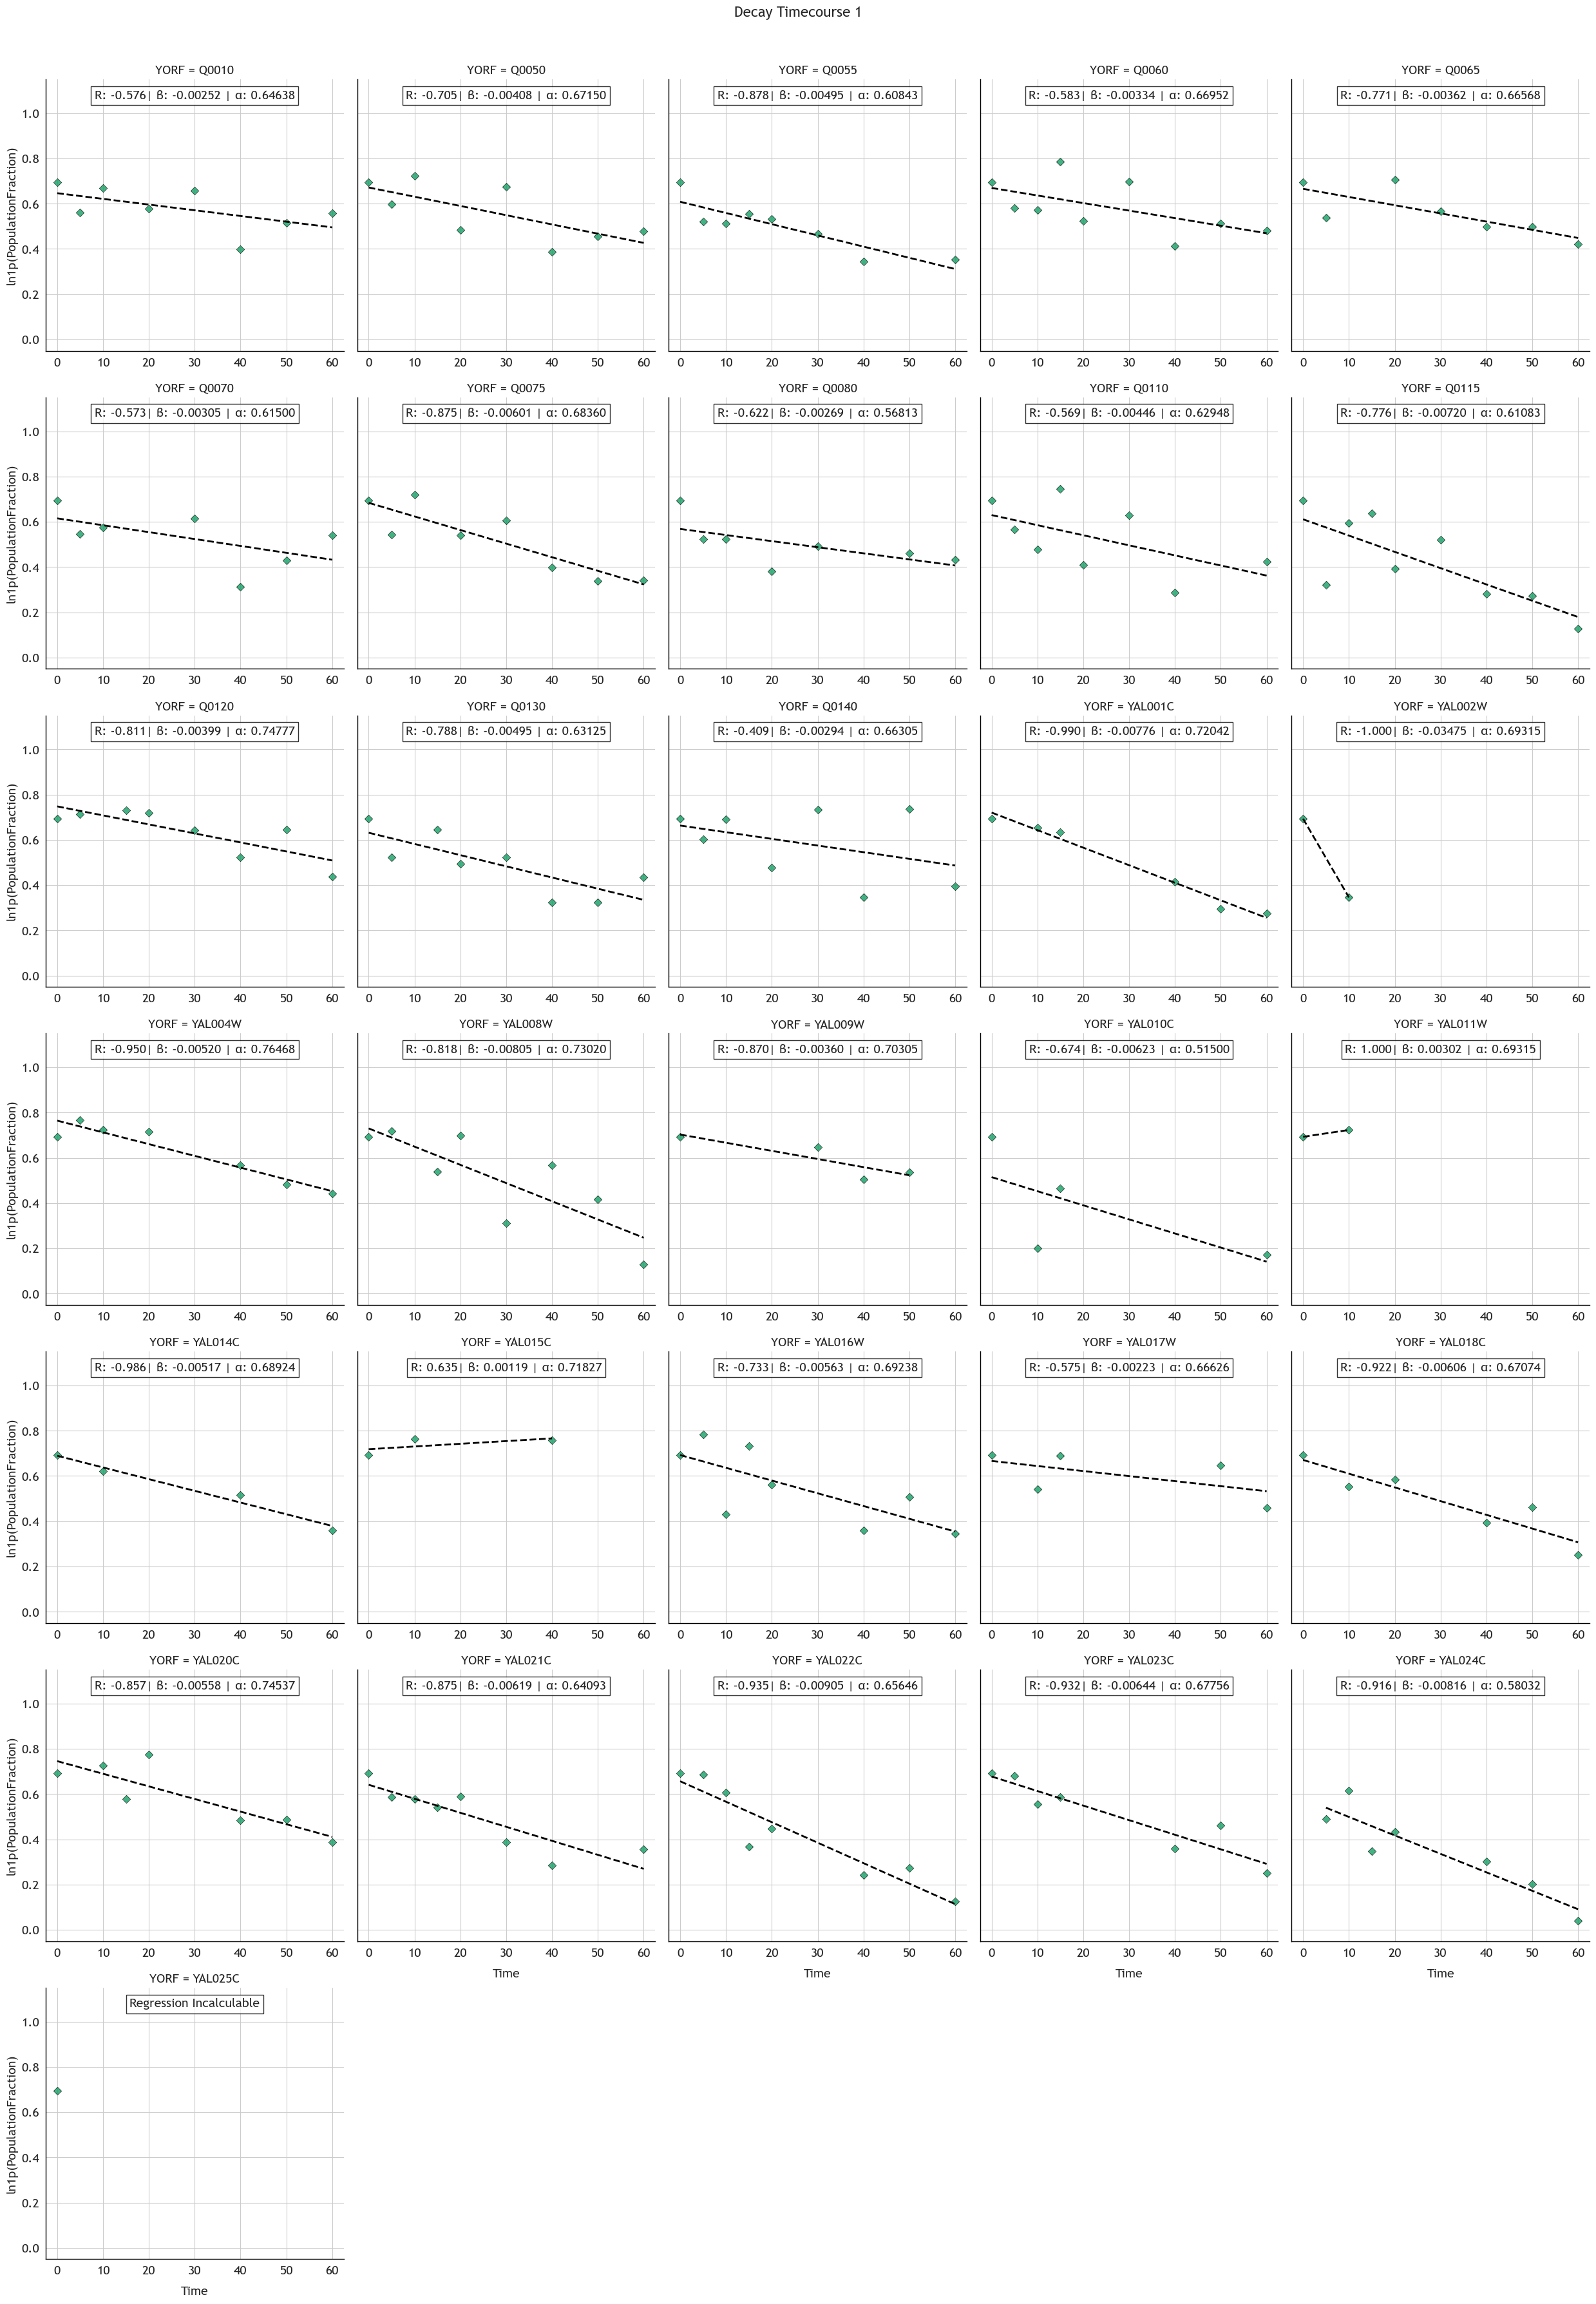

<Figure size 640x480 with 0 Axes>

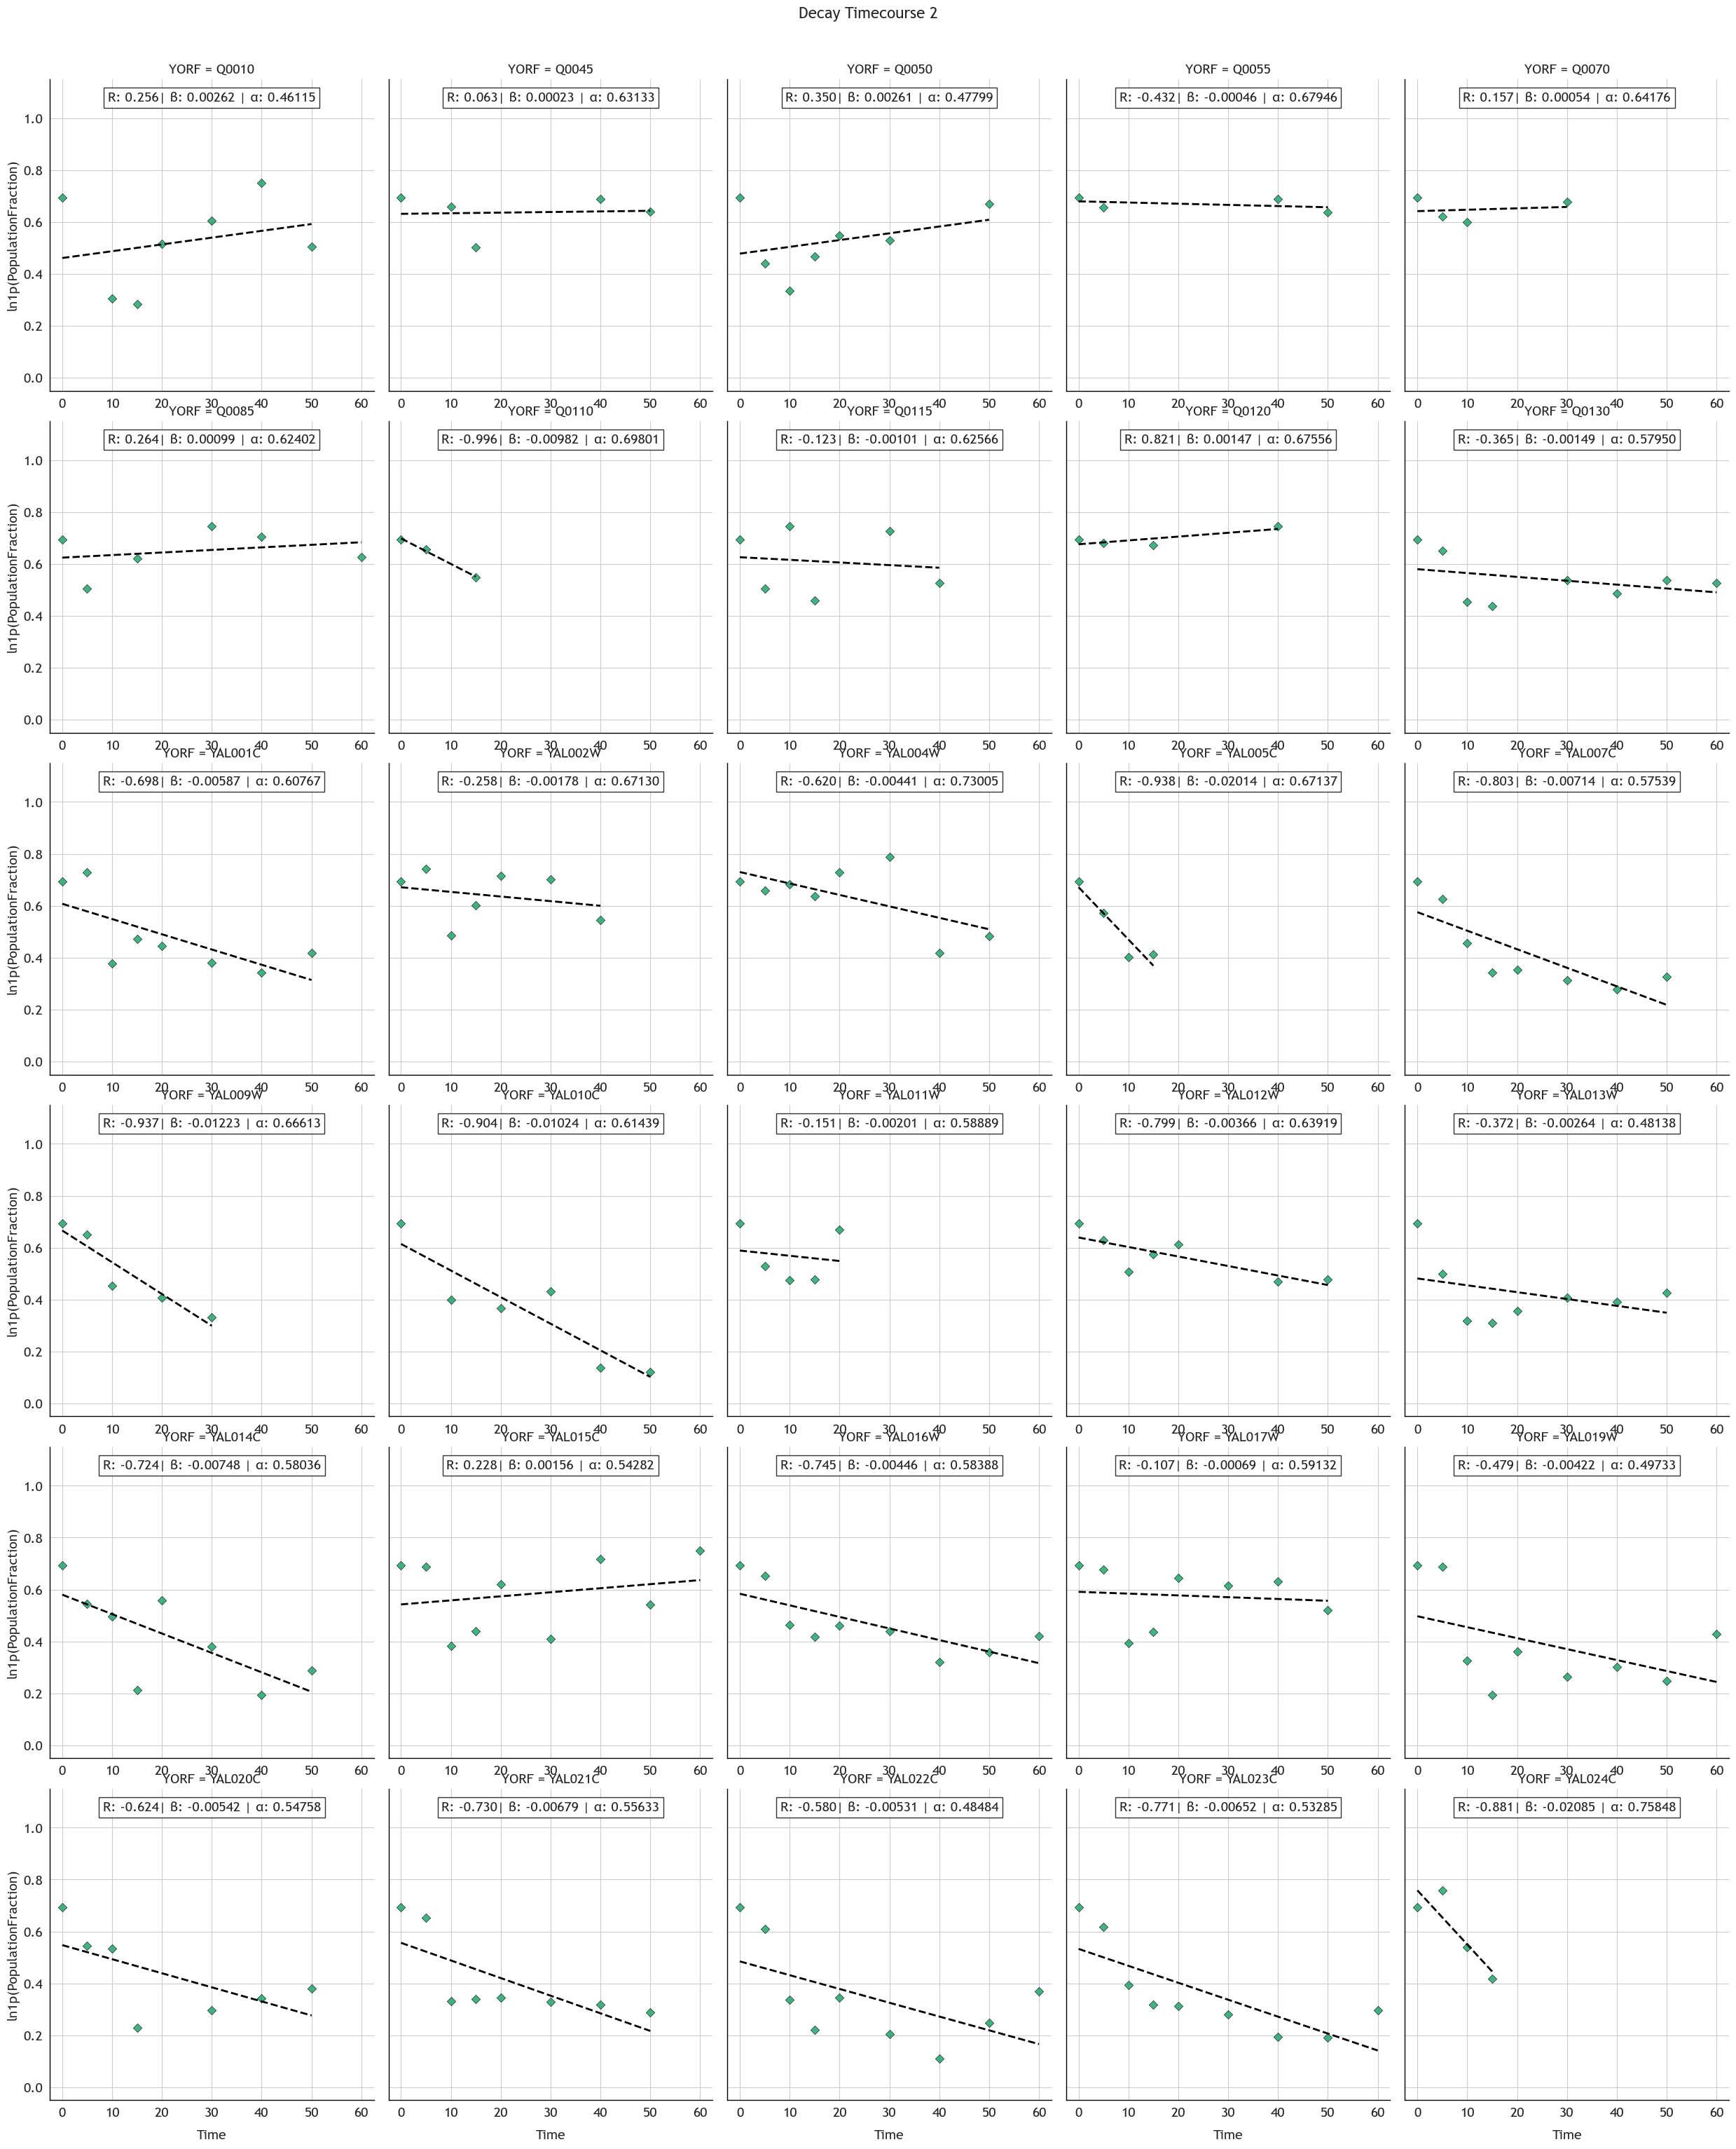

<Figure size 640x480 with 0 Axes>

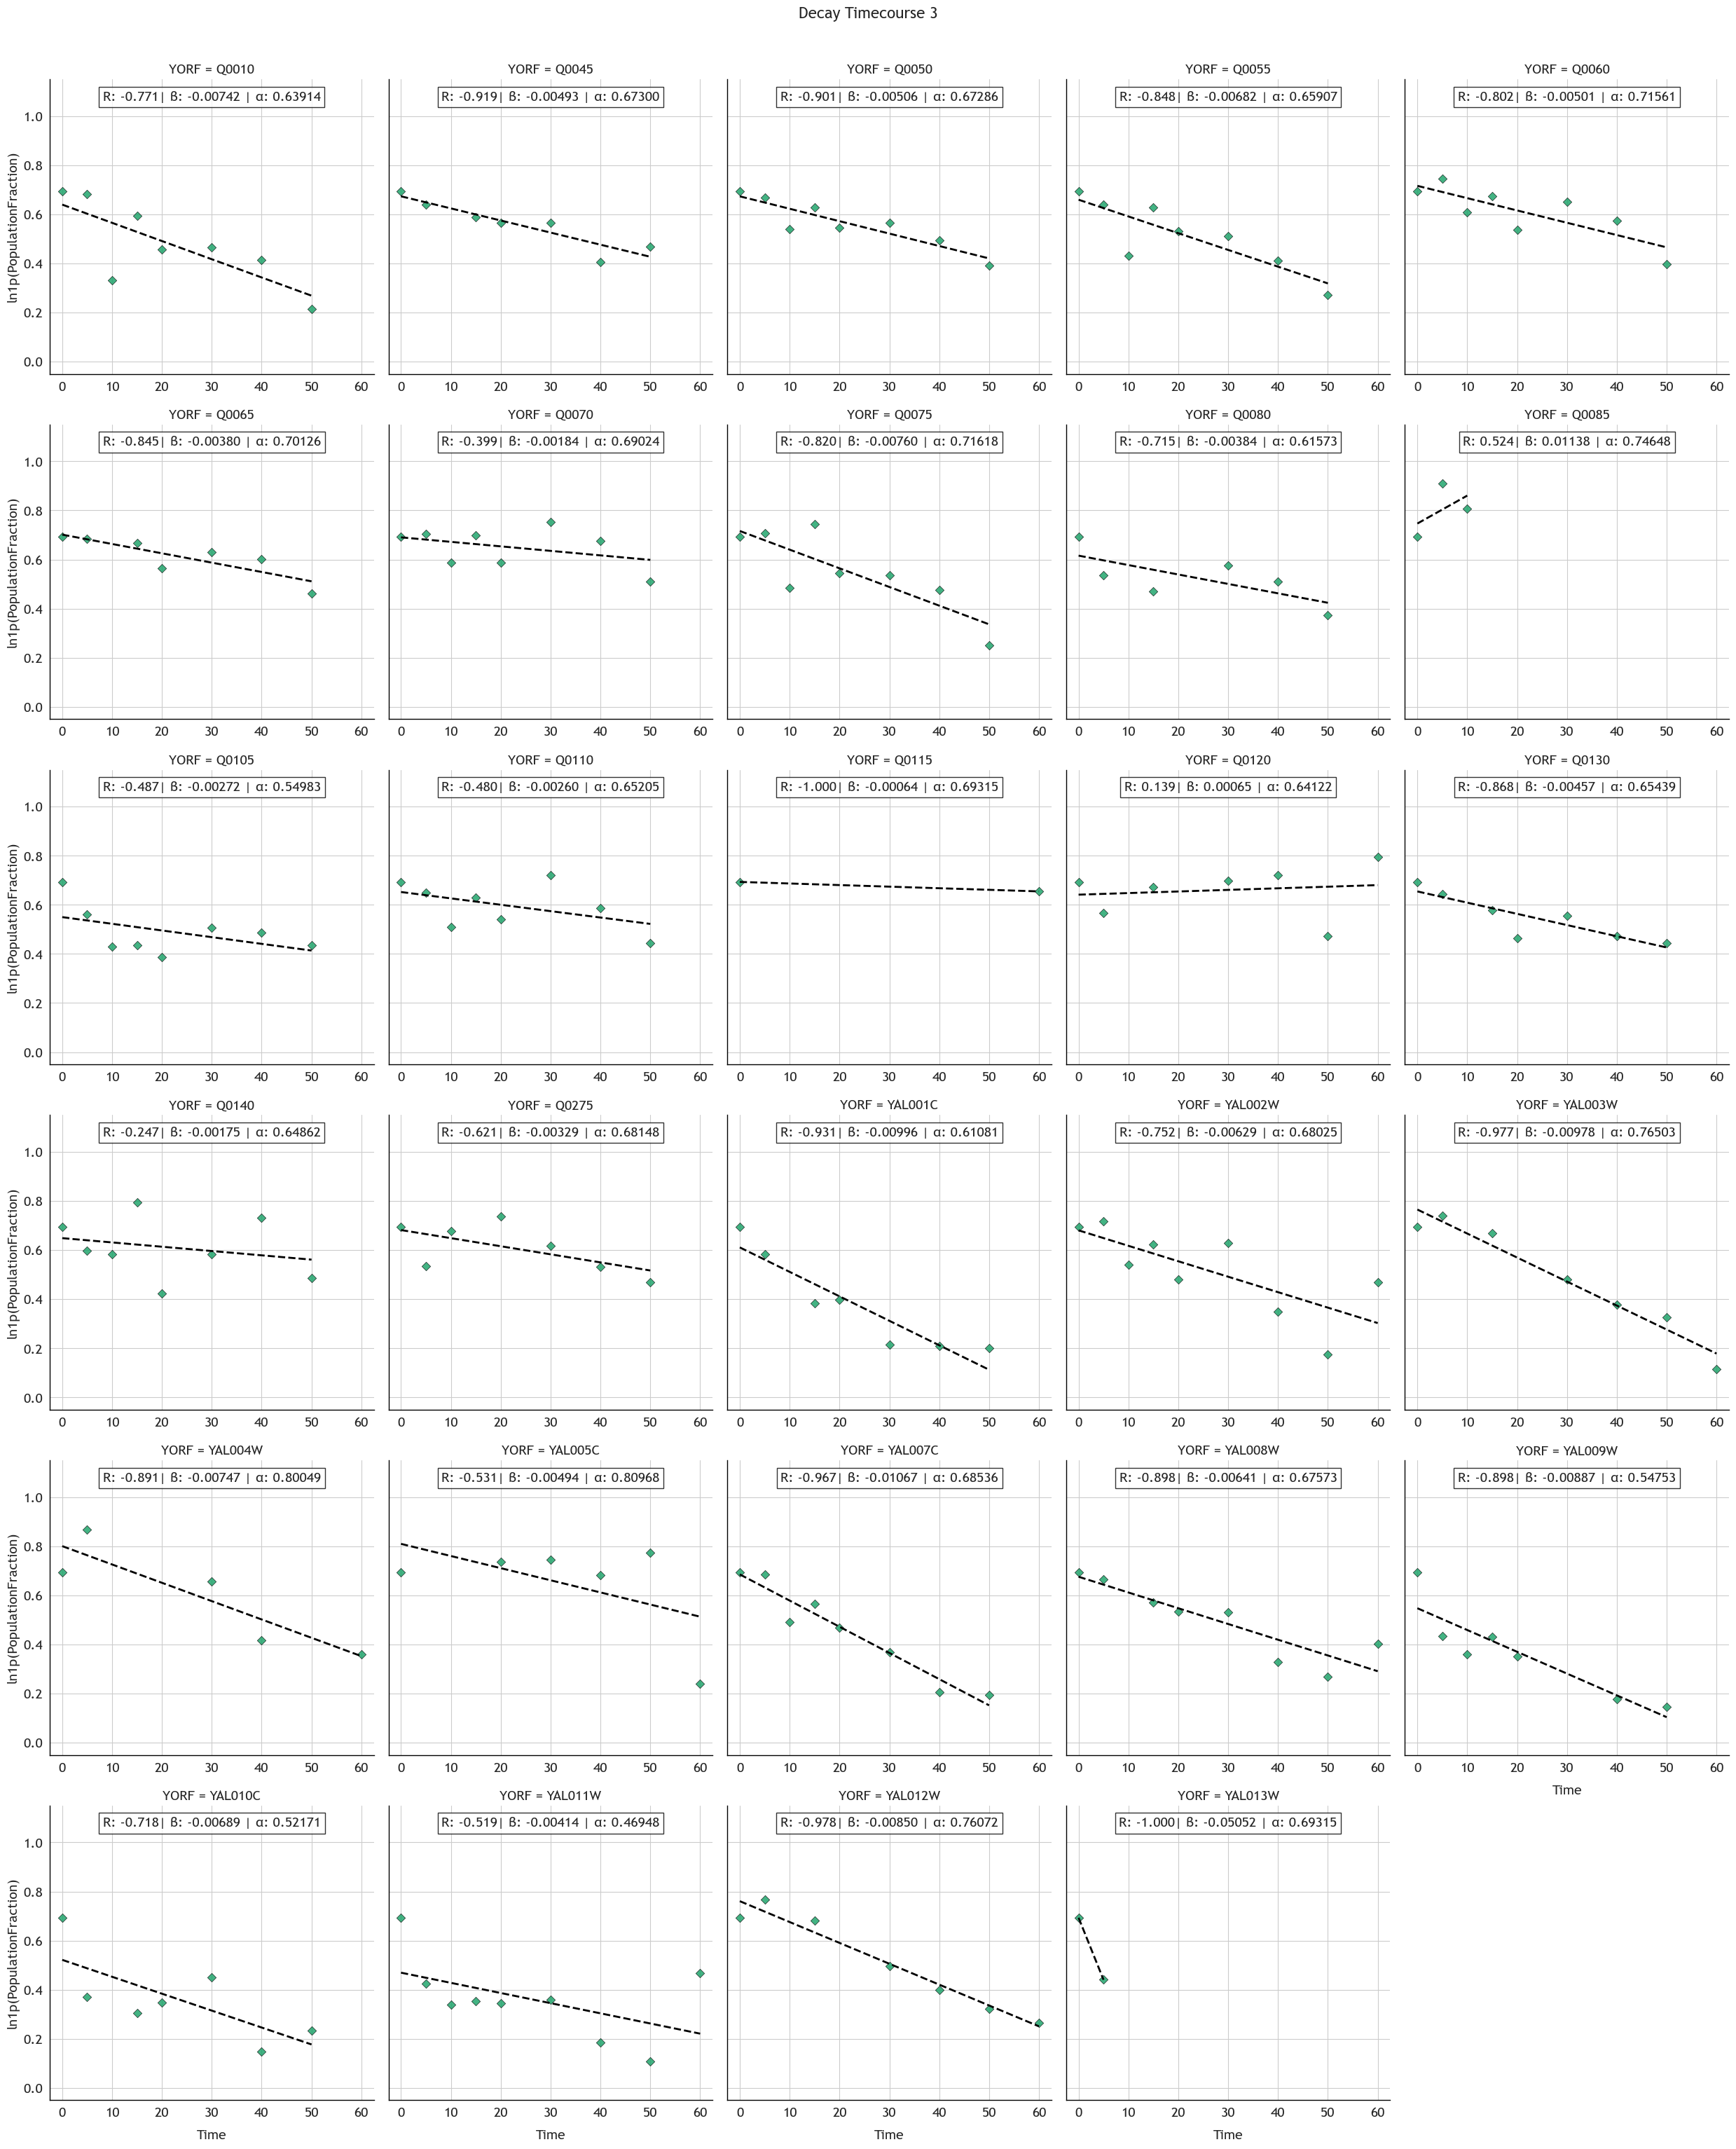

In [43]:
# Plot the Values to Check Linearity and Visually Validate the Regressions
# Note, can take a long time depending on the parameters!!

tuples_to_print = 200

for i,decay_timecourse_long_df in enumerate(decay_timecourse_long_dfs):
    
    # Remove the element with index 192 from DF 1 as it causes plotting issues for whatever reason
    if i == 0: decay_timecourse_long_df.drop(axis=0,index=192,inplace=True)
    
    # Plot the DF
    df_to_jay_lmplot(
        long_df=decay_timecourse_long_df[:tuples_to_print],
        x_values_column='Time',
        y_values_column='ln1p(PopulationFraction)',
        group_by_column='YORF',

        y_axis_bounds=(-0.05,1.15),
        x_axis_bounds=(-2.5,62.5),
        
        plot_x_aspect=4,
        plot_height=5,

        font_size_pt=14,
        plots_per_row=5,
        
        # Became annoying when adjusting amount of points to generate plots from
        super_plot_title=f"Decay Timecourse {i+1}",
        super_plot_title_y= 1.02,

        annotate_regression_label_pos_x = 0.5,
        annotate_regression_label_x_align= 'center',
        annotate_regression_label_pos_y = 0.94,
        annotate_regression_label_y_align= 'center',
        annotate_regression_label_digits = 5,
    )
    


In [45]:
################################
# Calculate Half-Life per YORF #
################################

# Create a dataframe to hold the half_lives
decay_timecourse_half_lives_dfs = []

# Threshold to Include the Slope or Drop it in the Half-Life Calc
# Drop Rows where the Half-Life Coefficient is less than 0.3 which suggests a weak fit
min_pearson_coef = 0.3

# Boolean flag to indicate whether the rate decay constant, which is expected as negative, should be dropped if positive
discard_positive_rate_decay_constants = True

# Iterate through the Regression DFs and Calculate Half Lives
for i,regression_df in enumerate(decay_timecourse_regressions_dfs):
    
    # Filter based on Pearson correlation coefficient threshold
    filtered_regression_df = regression_df[regression_df['r_coef'].abs() >= min_pearson_coef]

    if discard_positive_rate_decay_constants:
        # Further filter to exclude positive decay constants
        filtered_regression_df = filtered_regression_df[filtered_regression_df['slope'] < 0]

    # Drop all columns except for 'slope' to begin creation of the half life DF
    decay_timecourse_half_lives_df = filtered_regression_df[['slope']].copy()

    # Rename 'slope' column to 'decay_constant' 
    decay_timecourse_half_lives_df.rename(columns={'slope': 'decay_constant'}, inplace=True)

    # Calculate 'half_lives' using the formula ln(2)/abs(decay_constant)
    # and add it as a new column
    decay_timecourse_half_lives_df['half_life'] = np.log(2) / np.abs(decay_timecourse_half_lives_df['decay_constant'])

    # Append the Half Life DF to the List of Half_Life DFs
    decay_timecourse_half_lives_dfs.append(decay_timecourse_half_lives_df)

    # Debug to Validate the DF, display the Header
    print(f"Decay Timecourse {str(i+1)} Half Lives\n"
          f"------------------------------ \n "
          f"{decay_timecourse_half_lives_df.head(5)}\n\n")


Decay Timecourse 1 Half Lives
------------------------------ 
        decay_constant   half_life
YORF                             
Q0010       -0.004453  155.663993
Q0050       -0.007384   93.875530
Q0055       -0.010536   65.785557
Q0060       -0.005920  117.081765
Q0065       -0.006588  105.216928


Decay Timecourse 2 Half Lives
------------------------------ 
          decay_constant    half_life
YORF                                
Q0055         -0.000690  1005.079943
Q0110         -0.015968    43.408460
Q0130         -0.002264   306.197212
YAL001C       -0.011224    61.756835
YAL004W       -0.008111    85.456782


Decay Timecourse 3 Half Lives
------------------------------ 
        decay_constant  half_life
YORF                            
Q0010       -0.017253  40.174358
Q0045       -0.009040  76.679281
Q0050       -0.009474  73.163413
Q0055       -0.014889  46.553500
Q0060       -0.009077  76.366138


In [51]:
########################################
# Calculate Average Half-Life per YORF #
########################################

# Concatenate the list of DataFrames into one DataFrame Prior to Computation
all_half_lives_df = pd.concat(decay_timecourse_half_lives_dfs)

# Group by YORF and calculate the mean half_life for each YORF
# This averages the half_life across all time courses where the YORF appears
# Create a dataframe to hold the half_lives across all time courses
merged_decay_timecourse_half_lives_df = (all_half_lives_df.groupby(level=0)['half_life'].mean().reset_index())

# Rename the Half Life Column
merged_decay_timecourse_half_lives_df.rename(columns={'half_life': 'average_half_life'}, inplace=True)

# Calculate percentile ranks based on the average half life
merged_decay_timecourse_half_lives_df['half_life_percentile'] = merged_decay_timecourse_half_lives_df['average_half_life'].rank(pct=True)

# Sort by the percentile rank of the average half life such that longest half-life is first
merged_decay_timecourse_half_lives_df.sort_values(by='half_life_percentile', ascending=False,  inplace=True)

# Sort by the percentile rank of the average half life
merged_decay_timecourse_half_lives_df.reset_index(drop=True, inplace=True)

# Debug to Validate the DF, display the Header
print(f" All Decay Timecourse Half Lives\n"
      f"------------------------------ \n "
      f"{merged_decay_timecourse_half_lives_df}\n\n")

 All Decay Timecourse Half Lives
------------------------------ 
            YORF  average_half_life  half_life_percentile
0       YGR146C        3252.332359              1.000000
1       YGL256W        2113.116237              0.999837
2       YMR250W        1045.287397              0.999673
3       YIR017C         809.076433              0.999510
4       YCR010C         714.696812              0.999347
...         ...                ...                   ...
6119    YDR543C           3.523816              0.000816
6120    YER189W           3.461682              0.000653
6121    YIR027C           3.425607              0.000490
6122  YEL076C-A           3.386783              0.000327
6123    YER190W           2.136603              0.000163

[6124 rows x 3 columns]


In [62]:
########################################
# Output and Save the Signficant YORFs #
########################################

# Set the Threshold for the Percentage of YORFs to Save
# Default is 0.1, so top 10% and bot 10% are deemed significant and saved
significance_level = 0.1

# Filter for top 10% of YORFs based on their half-life percentile which is 1 - Significance Level
top_YORFs_df = merged_decay_timecourse_half_lives_df[merged_decay_timecourse_half_lives_df['half_life_percentile'] >= (1-significance_level)]

# Filter for bottom 10% of YORFs based on their half-life percentile which is just the Significance Level
bot_YORFs_df = merged_decay_timecourse_half_lives_df[merged_decay_timecourse_half_lives_df['half_life_percentile'] <= significance_level]

# Reverse the Order of the Bot YORFs such that the most significant is at the Top of the List:
bot_YORFs_df = bot_YORFs_df.iloc[::-1].reset_index(drop=True)


# Round the Significance Level
significance_level = int(significance_level*100)

# Print Each DF and Save It as CSV
for key,YORFs_df in {'Top':top_YORFs_df, 'Bot':bot_YORFs_df}.items():
    # Print the DF to Validate it
    print(f" {key} {significance_level}% YORF by Half Lives\n"
          f"--------------------------- \n "
          f"{YORFs_df}\n\n")

    # Output Directory is already defined as 'output_folder'

    # Save Just the YORFs to CSV
    YORFs_df['YORF'].to_csv(f"{output_folder}{key}{significance_level}_YORFs.csv", header=False,index=False)
    


 Top 10% YORF by Half Lives
--------------------------- 
         YORF  average_half_life  half_life_percentile
0    YGR146C        3252.332359              1.000000
1    YGL256W        2113.116237              0.999837
2    YMR250W        1045.287397              0.999673
3    YIR017C         809.076433              0.999510
4    YCR010C         714.696812              0.999347
..       ...                ...                   ...
608  YNL338W          79.602215              0.900718
609  YKR023W          79.509361              0.900555
610  YKL139W          79.499968              0.900392
611  YDR305C          79.499449              0.900229
612  YPR150W          79.495107              0.900065

[613 rows x 3 columns]


 Bot 10% YORF by Half Lives
--------------------------- 
           YORF  average_half_life  half_life_percentile
0      YER190W           2.136603              0.000163
1    YEL076C-A           3.386783              0.000327
2      YIR027C           3.425607         

In [57]:
#################
# End of Script #
#################
